In [1]:
import pandas as pd
from gensim.models import Word2Vec
import numpy as np
import logging
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import os
import time
import uuid

# Define the main directory where your container data directories are located
main_directory = '/home/razine.ghorab/projects/projectX/test_all/clustering/high_containers'  # Update with the correct path

# Get a list of subdirectories (each representing a container) within the main directory
container_directories = [d for d in os.listdir(main_directory) if os.path.isdir(os.path.join(main_directory, d))]

# Create a DataFrame for your overall results
#results_df = pd.DataFrame(columns=['Container Name', 'MAE LSTM', 'MAE Past', 'Total CPU Data', 'Training Time Word2Vec', 'Training Time LSTM'])

# List of k_percentage values to try
embedding_sizes = [8,16,32]
window_sizes=[1,5,10]

# Initialize a master DataFrame to store results for all containers
master_df = pd.DataFrame()

# Set a counter variable to control the number of iterations
counter_limit = 2
counter = 0



# Process each container directory and its CSV file
for container_directory in container_directories:
    if counter >= counter_limit:
        break  # Exit the loop if the counter exceeds the limit
    
    #counter = counter + 1
    container_directory_path = os.path.join(main_directory, container_directory)

    # Find the CSV file inside the container directory
    csv_files = [f for f in os.listdir(container_directory_path) if f.endswith('original.csv')]

    if not csv_files:
        print(f"No CSV files found in the directory: {container_directory_path}")
        continue

    container_file_path = os.path.join(container_directory_path, csv_files[0])

    # Create a DataFrame for the current container
    
    container_df = pd.DataFrame(columns=['unique_id'])
    container_df.loc[0,'unique_id'] = csv_files[0].replace('.csv', '')
    print(csv_files[0])
    

    df = pd.read_csv(container_file_path)

    cpu_data = df['CPU Usage Percentage'].tolist()
    cpu_data = [str(cpu) for cpu in cpu_data]
    container_df.loc[0,'dict_len'] = len(set(cpu_data))

    sequence_length = len(cpu_data)
    sequences = [cpu_data[i * sequence_length:(i + 1) * sequence_length] for i in range(len(cpu_data) // sequence_length)]

    

    # Load and preprocess your data
    data = df
    cpu_values = data['CPU Usage Percentage'].values.astype(float)


    k=32


    for embedding in embedding_sizes:
        

        model = Word2Vec(sequences, vector_size=embedding, window=5, min_count=1, sg=1, compute_loss=True, epochs=200)
        
        
        word_vectors = model.wv
        intersection_count = 0
        new_cpu_data_mea1=[]
       

        if len(cpu_data) > 3:
            for i in range(3, len(cpu_data)):
                # Get the previous 3 cpu_values

                cpu_values = [ cpu_data[i-3],cpu_data[i-2], cpu_data[i-1]]
                
                
                # Total number of context words
                n_words = len(cpu_values)
    
                # Compute weighted average vector
                # Linearly decreasing weights from n_words to 1
                weights = np.linspace(1, n_words, n_words)
                #weights=[1,1,1]
                weighted_vectors = np.zeros(word_vectors.vector_size)

                for word, weight in zip(cpu_values, weights):
                    if word in word_vectors:
                        weighted_vectors += word_vectors[word] * weight
                
                avg_vector = weighted_vectors / np.sum(weights)
                # Find the closest word to the average vector
                closest_words = word_vectors.similar_by_vector(avg_vector, topn=k)
              
                closest_words=[word for word, similarity in closest_words]
                
                # If the current cpu_value is in the intersection, you might want to count or track it
                if cpu_data[i] in closest_words:
                    intersection_count += 1
                    new_cpu_data_mea1.append(cpu_data[i])
                    
                else:
                    
                    # Convert closest_words to a list of integers
                    numbers = list(map(int, closest_words))

                    # Sort the numbers based on their absolute difference from the target number
                    sorted_numbers = sorted(numbers, key=lambda x: abs(x - int(cpu_data[i])))

                    
                    # Take the 5 closest numbers
                    five_closest_numbers = sorted_numbers[:k]

                    # Convert these numbers to strings and append them to new_cpu_data
                    new_cpu_data_mea1.append(str(five_closest_numbers[0]))
                        
                



                    

            mae1_word2Vec = mean_absolute_error(list(map(int, cpu_data[3:])), list(map(int, new_cpu_data_mea1)))
            
            container_df.loc[0,'mea_embedding_'+str(embedding)] = mae1_word2Vec
            container_df.loc[0,'accuracy_embedding_'+str(embedding)] = intersection_count / (len(cpu_data) - 3)

    for window in window_sizes:
        

        model = Word2Vec(sequences, vector_size=16, window=window, min_count=1, sg=1, compute_loss=True, epochs=200)
        
        word_vectors = model.wv
        intersection_count = 0
        new_cpu_data_mea1=[]
       

        if len(cpu_data) > 3:
            for i in range(3, len(cpu_data)):
                # Get the previous 3 cpu_values

                cpu_values = [ cpu_data[i-3],cpu_data[i-2], cpu_data[i-1]]
                
                
                # Total number of context words
                n_words = len(cpu_values)
    
                # Compute weighted average vector
                # Linearly decreasing weights from n_words to 1
                weights = np.linspace(1, n_words, n_words)
                #weights=[1,1,1]
                weighted_vectors = np.zeros(word_vectors.vector_size)

                for word, weight in zip(cpu_values, weights):
                    if word in word_vectors:
                        weighted_vectors += word_vectors[word] * weight
                
                avg_vector = weighted_vectors / np.sum(weights)
                # Find the closest word to the average vector
                closest_words = word_vectors.similar_by_vector(avg_vector, topn=k)
                closest_words=[word for word, similarity in closest_words]
                # If the current cpu_value is in the intersection, you might want to count or track it
                if cpu_data[i] in closest_words:
                    intersection_count += 1
                    new_cpu_data_mea1.append(cpu_data[i])
                    
                else:
                    # Convert closest_words to a list of integers
                    numbers = list(map(int, closest_words))

                    # Sort the numbers based on their absolute difference from the target number
                    sorted_numbers = sorted(numbers, key=lambda x: abs(x - int(cpu_data[i])))

                    
                    # Take the 5 closest numbers
                    five_closest_numbers = sorted_numbers[:k]

                    # Convert these numbers to strings and append them to new_cpu_data
                    new_cpu_data_mea1.append(str(five_closest_numbers[0]))
                        
             
            mae1_word2Vec = mean_absolute_error(list(map(int, cpu_data[3:])), list(map(int, new_cpu_data_mea1)))
            
            container_df.loc[0,'mea_window_'+str(window)] = mae1_word2Vec
            container_df.loc[0,'accuracy_window_'+str(window)] = intersection_count / (len(cpu_data) - 3)        

  

    master_df = pd.concat([master_df, container_df], ignore_index=True)

# Save the results DataFrame to a CSV file
master_df.to_csv('word2vec_sensitivity.csv', index=False)

print("Results saved to 'word2vec_sensitivity.csv'")


2024-03-20 12:53:03.099184: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-20 12:53:03.099256: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-20 12:53:03.099270: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-20 12:53:03.103851: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-20 12:53:03.820662: W tensorflow/compiler/

text-service_net_erms_original.csv
nginx-web-server_net_erms_original.csv
socialnetwork-post-storage-mongodb_local_original.csv
recommendation_hotel_erms_original.csv
profile_hotel_erms_original.csv
reservation_hotel_erms_original.csv
socialnetwork-jaeger-agent_local_original.csv
url-shorten-mongodb_local_original.csv
socialnetwork-user-timeline-mongodb-1_original.csv
frontend_hotel_erms_original.csv
search_hotel_erms_original.csv
socialnetwork-home-timeline-redis-1_local_original.csv
compose-post-service_net_erms_original.csv
Results saved to 'word2vec_sensitivity.csv'


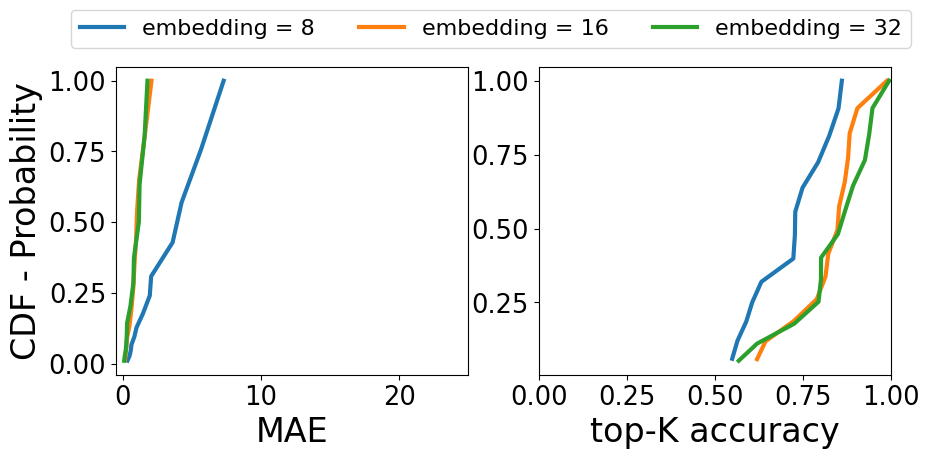

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# Read the data
data_mae = pd.read_csv('/home/razine.ghorab/projects/projectX/paper_figures/word2vec_sensitivity.csv')
data_acc = pd.read_csv('/home/razine.ghorab/projects/projectX/paper_figures/word2vec_sensitivity.csv')

# Rename the columns
data_mae = data_mae.rename(columns={"mea_embedding_8":"embedding = 8","mea_embedding_16":"embedding = 16","mea_embedding_32":"embedding = 32",})
data_acc = data_acc.rename(columns={"accuracy_embedding_8":"embedding = 8","accuracy_embedding_16":"embedding = 16", "accuracy_embedding_32":"embedding = 32"})

# Define the columns to plot
columns = ["embedding = 8", "embedding = 16","embedding = 32"]

# Set a larger figure size to accommodate the plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# List to store legend handles and labels
legend_handles = []
legend_labels = []

# Plot for MAE
for column in columns:
    forecasting = data_mae[column]
    forecasting = np.sort(forecasting)
    cdf = np.cumsum(forecasting) / np.sum(forecasting)
    handle, = ax1.plot(forecasting, cdf, label=f'{column}',lw=3)
    #legend_handles.append(handle)
    #legend_labels.append(f'{column}')

ax1.set_xlabel('MAE', fontsize=24)
ax1.set_xlim((-0.5,25))
ax1.set_ylabel('CDF - Probability',fontsize=24)
ax1.tick_params(axis='both', which='major', labelsize=18.5)

# Plot for Accuracy
for column in columns:
    forecasting = data_acc[column]
    forecasting = np.sort(forecasting)
    cdf = np.cumsum(forecasting) / np.sum(forecasting)
    handle, = ax2.plot(forecasting, cdf, label=f'{column}',lw=3)
    legend_handles.append(handle)
    legend_labels.append(f'{column}')

ax2.set_xlabel('top-K accuracy', fontsize=24)
ax2.set_xlim((0,1))


ax2.tick_params(axis='both', which='major', labelsize=18.5)
#plt.xticks(fontsize=16)
# Create a single legend outside the figure
fig.legend(legend_handles, legend_labels, loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.05), fontsize=16)

plt.savefig("embedding_size.pdf",format="pdf", bbox_inches="tight")
plt.show()

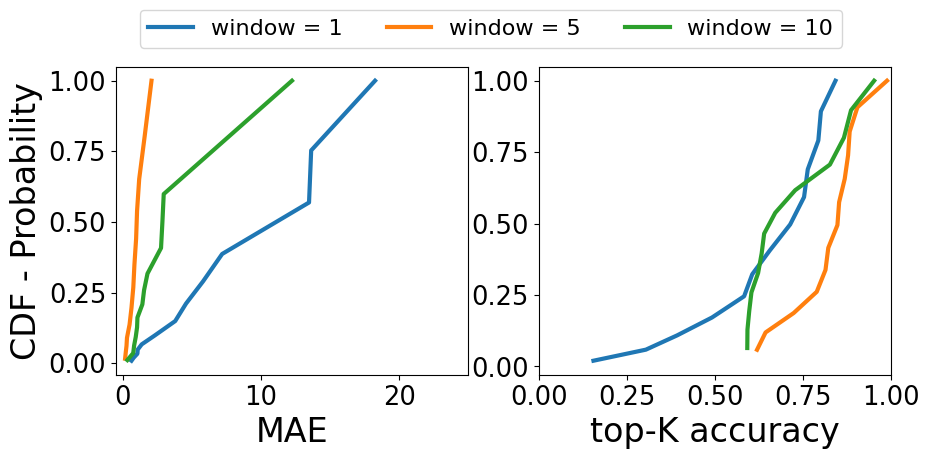

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# Read the data
data_mae = pd.read_csv('/home/razine.ghorab/projects/projectX/paper_figures/word2vec_sensitivity.csv')
data_acc = pd.read_csv('/home/razine.ghorab/projects/projectX/paper_figures/word2vec_sensitivity.csv')

# Rename the columns
data_mae = data_mae.rename(columns={"mea_window_1":"window = 1","mea_window_5":"window = 5","mea_window_10":"window = 10",})
data_acc = data_acc.rename(columns={"accuracy_window_1":"window = 1","accuracy_window_5":"window = 5", "accuracy_window_10":"window = 10"})

# Define the columns to plot
columns = ["window = 1", "window = 5","window = 10"]

# Set a larger figure size to accommodate the plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# List to store legend handles and labels
legend_handles = []
legend_labels = []

# Plot for MAE
for column in columns:
    forecasting = data_mae[column]
    forecasting = np.sort(forecasting)
    cdf = np.cumsum(forecasting) / np.sum(forecasting)
    handle, = ax1.plot(forecasting, cdf, label=f'{column}',lw=3)
    #legend_handles.append(handle)
    #legend_labels.append(f'{column}')

ax1.set_xlabel('MAE', fontsize=24)
ax1.set_ylabel('CDF - Probability',fontsize=24)
ax1.set_xlim((-0.5,25))
ax1.tick_params(axis='both', which='major', labelsize=18.5)

# Plot for Accuracy
for column in columns:
    forecasting = data_acc[column]
    forecasting = np.sort(forecasting)
    cdf = np.cumsum(forecasting) / np.sum(forecasting)
    handle, = ax2.plot(forecasting, cdf, label=f'{column}',lw=3)
    legend_handles.append(handle)
    legend_labels.append(f'{column}')

ax2.set_xlabel('top-K accuracy', fontsize=24)

ax2.set_xlim((0,1))
ax2.tick_params(axis='both', which='major', labelsize=18.5)
#plt.xticks(fontsize=16)
# Create a single legend outside the figure
fig.legend(legend_handles, legend_labels, loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.05), fontsize=16)

plt.savefig("window_size.pdf",format="pdf", bbox_inches="tight")
plt.show()

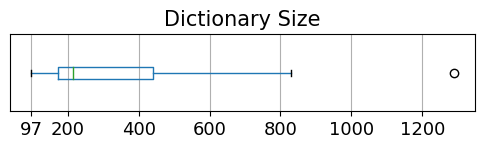

In [3]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# Read the CSV file into a pandas DataFrame
df = pd.read_csv('/home/razine.ghorab/projects/projectX/paper_figures/word2vec_sensitivity.csv')

# Create a horizontal box plot for 'dict_len'
plt.figure(figsize=(6, 1))  # Increased figure size
ax = df.boxplot(column='dict_len', vert=False)
plt.title('Dictionary Size',fontsize=15)

# Remove y-axis labels
ax.set_yticks([])

# Get the minimum value of 'dict_len'
min_value = df['dict_len'].min()

# Add a vertical line at the minimum value
#plt.axvline(min_value, color='r', linestyle='--', label='Minimum Value')

# Set custom x-axis ticks and labels
xtick_positions = [97, 200,400,600,800,1000,1200]
xtick_labels = [str(97)] + ["200", "400", "600" ,"800" ,"1000" ,"1200" ]
plt.xticks(xtick_positions, xtick_labels)
plt.xticks(fontsize=13)
# Add a legend

plt.savefig("dictionary_size.pdf",format="pdf", bbox_inches="tight")
plt.show()